# Исследование надежности заемщиков

# ПРЕДОБРАБОТКА ДАННЫХ

Обзор данных. Импорт библиотеки pandas, чтение файла, ознакомление с содержимым. 

In [1]:
# импорт библиотеки pandas
import pandas as pd

import matplotlib.pyplot as plt
# чтение файла и сохранение его в переменной
try:
    data = pd.read_csv('/Users/onelev/shkoding/datasets/bank_data.csv')
except:
    data = pd.read_csv('/datasets/data.csv')
# просмотр 5 первых строк, чтобы ознакомится с содержимым
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


## Определение и заполнение пропусков

In [2]:
# просмотрю общие сведения о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Столбцы дни стажа и суммарный доход имеют меньшее количество данных, значит там могут находится пропуски. Проверим это.

In [3]:
# определю в каких столбцах и в каком количестве имеются пропуски
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

В колонках 'days_employed' и 'total_income' присутствуют эквивалентное количество пропусков. 
Первая колонка - это, по-видимому, сколько человек работает, второе - суммарный доход. 
Очевидно что пропуски взаимосвязаны, поскольку не работая человек не получает дохода. 

Проверим, сколько процентов от суммарного колличества данных занимают пропуски. 

Поскольку в обоих случаях количество пропусков одинаково, то и доля будет идентична. 

In [4]:
# посчитаю долю пропущенных значений в столбцах
data['days_employed'].isna().sum() / data['days_employed'].count() * 100

11.234561521368406

Теперь мы знаем что доля пустых значения равняется 11%. 

Далее, заменим все пропуски на медианные значения. Здесь будем использовать именно медианные значения, поскольку количество дней, которое человек работает и достаток могут значительно отличаться от человека к человеку. Таким образом средние значения могут слишком занижать или завышать значение. Медиана будет более репрезентативна.

In [5]:
total_median = data.groupby('income_type')['total_income'].median()

data.loc[(data['total_income'].isna()) & (data['income_type'] == 'сотрудник'), 'total_income'] = total_median[6]
data.loc[(data['total_income'].isna()) & (data['income_type'] == 'пенсионер'), 'total_income'] = total_median[4]
data.loc[(data['total_income'].isna()) & (data['income_type'] == 'компаньон'), 'total_income'] = total_median[3]
data.loc[(data['total_income'].isna()) & (data['income_type'] == 'госслужащий'), 'total_income'] = total_median[2]
data.loc[(data['total_income'].isna()) & (data['income_type'] == 'предприниматель'), 'total_income'] = total_median[-3]

display(data['total_income'].isna().sum())         

0

In [6]:
# заменю пропуски медианными значениями по столбцу
data['days_employed'] = data['days_employed'].fillna(data['days_employed'].median())
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

## Замена вещественного типа данных на целочисленный

In [7]:
data['total_income'] = data['total_income'].astype('int')

## АНОМАЛИИ

1. В столбце дни стажа значения отрицательные, и некоторые очевидно гораздо больше чем должны быть. Исправлю это.

In [8]:
#избавлюсь от отрицательных значений
data['days_employed'] = abs(data['days_employed'])
display(data['days_employed'])

0          8437.673028
1          4024.803754
2          5623.422610
3          4124.747207
4        340266.072047
             ...      
21520      4529.316663
21521    343937.404131
21522      2113.346888
21523      3112.481705
21524      1984.507589
Name: days_employed, Length: 21525, dtype: float64

Очевидно, что в некоторых строках количество дней слишком велико, чтобы это уточнить переведу дни в года (для простоты буду использовать 365дней = 1 год)

In [9]:
# проверю каков стаж в годах
data['days_employed'] = data['days_employed'] / 365

# поскольку в некоторых случаях стаж равен 900 годам, заменю такие аномалии
# на средние 30 лет рабочего стажа
data.loc[(data['days_employed'] >= data['dob_years']), 'days_employed'] = 30
# изменю название, поскольку это уже не дни работы
data = data.rename(columns = {'days_employed' : 'years_employed'})
# приведу к целочисленному формату для удобства
data['years_employed'] = data['years_employed'].astype('int')

2. в колонке с гендером имеется странный XNA, решила заменить его на 'M'

In [10]:
# проверю уникальные наименования в столбце  гендер
data['gender'].value_counts()
# удалю строку с XNA гендером
data = data.loc[data['gender'] != 'XNA']
# проверю результат
data['gender'].value_counts()

F    14236
M     7288
Name: gender, dtype: int64

3. В колонке с детьми есть отрицательные значения, а также у кого-то 20 детей.

In [11]:
# проверим аномалии в колонке дети
data['children'].value_counts()
# поменяем отрицательные значения на положительные
data['children'] = abs(data['children'])
# изменим 20 детей на 2
data.loc[data['children'] == 20, 'children'] = 2

4. Проверим аномалии в столбце возраста 

In [12]:
# сгруппируем и отсортируем колонку по возрасту, видим что есть возраст равный 0
data.sort_values(by='dob_years').groupby('dob_years')['dob_years'].count()
# оставим в таблице только значения удовлетворяющие условию
data = data.loc[data['dob_years'] != 0]

## Поиск дубликатов

In [13]:
# посмотри уникальные значения столбца образование
data['education'].value_counts()

среднее                13691
высшее                  4686
СРЕДНЕЕ                  770
Среднее                  708
неоконченное высшее      665
ВЫСШЕЕ                   273
Высшее                   266
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

Приведем все значения к нижнему регистру и проверим после еще раз количество уникальных наименований. 
Таким образом мы избавимся от дубликатов, возникших из-за использования разного регистра при написании.

In [14]:
# привожу все значения к нижнему регистру
data['education'] = data['education'].str.lower()
# проверяю как изменился список уникальных значений
data['education'].value_counts()

среднее                15169
высшее                  5225
неоконченное высшее      741
начальное                282
ученая степень             6
Name: education, dtype: int64

Проведем ту же операцию для колонок семейный статус, тип дохода и цели получения заема.

In [15]:
# проверим семейный статус
data['family_status'].value_counts()
# проверим источник дохода
data['income_type'].value_counts()
# проверим цель получения заема
data['purpose'].value_counts()

свадьба                                   792
на проведение свадьбы                     773
сыграть свадьбу                           769
операции с недвижимостью                  673
покупка коммерческой недвижимости         661
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     649
операции с жильем                         647
покупка жилья                             641
жилье                                     641
покупка жилья для семьи                   640
строительство собственной недвижимости    633
операции со своей недвижимостью           630
недвижимость                              630
строительство жилой недвижимости          623
строительство недвижимости                620
покупка недвижимости                      620
покупка своего жилья                      619
ремонт жилью                              610
покупка жилой недвижимости                604
на покупку своего автомобиля              502
заняться высшим образованием      

In [16]:
# проверила наличие дубликатов
data.duplicated().sum()
# удалила дубликаты, сбросила индексы
data = data.drop_duplicates().reset_index(drop=True)

Очевидно что здесь большое количество дубликатов, но мы не будем удалять их на данном этапе, в дальнейшем напишем функцию, которая разлбьет все это на 4 основные категотрии.

In [17]:
# создам отдельный словарь с кодом семьи и статусом, удалю дубликаты
education_dict = data[['education_id', 'education']].drop_duplicates().reset_index(drop=True)
#display(education_dict)
# создам словарь с кодом образования и наименованием образования, удалю дубликаты, сброшу индексы
family_dict = data[['family_status_id', 'family_status']].drop_duplicates().reset_index(drop=True)
#display(family_dict)
# удалю столбцы семейный статус и образование, оставив только их id
del data['family_status']
del data['education']

## Категоризация данных

Напишу функцию, которая будет принимать в качестве аргумента заработок клиента, 
присваивая ему категорию согласно заданным диапазонам.

In [18]:
def incomes(income):
    if 0 <= income <= 30000:
        return 'E'
    elif 30001 <= income <= 50000:
        return 'D'
    elif 50001 <= income <= 200000:
        return 'C'
    elif 200001 <= income <= 1000000:
        return 'B'
    else:
        return 'A'

In [19]:
# создам отдельный столбец, в которм будут присвоенные буквенные обозначения по уровню дохода
data['total_income_category'] = data['total_income'].apply(incomes)
# удалю суммарный заработок, оставив столбец с буквенным обозначением категории
del data['total_income']

На основании данных из столбца "цели", выделим 4 основные категории заема:
    -1)Проведение свадеб
    -2)Получение образования
    -3)Операции с автомобилем
    -4)Операции с недвижимостью

In [20]:
# функция будет принимать в качестве аргумента значение колонки цель заема,
# по ключевым словам будет определяться категория
def purposes(value):
    if 'свадьб' in value:
        return 'проведение свадьбы'
    elif 'образов' in value:
        return 'получение образования'
    elif 'автомоб' in value:
        return 'операции с автомобилем'
    elif 'недвиж' or 'жиль' in value:
        return 'операции с недвижимостью'

# добавим в датасет столбец  
data['purpose_category'] = data['purpose'].apply(purposes)

## Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [21]:
# сгруппирую данные и выведу долю должников
children_data = data.groupby(['children'])['debt'].mean().reset_index().sort_values(by='children')
# уберу данные, где кол-во детей - 5
children_data = children_data.loc[children_data['children'] != 5]
display(children_data)

,children,debt
0,0,0.075458
1,1,0.091341
2,2,0.095553
3,3,0.082317
4,4,0.097561


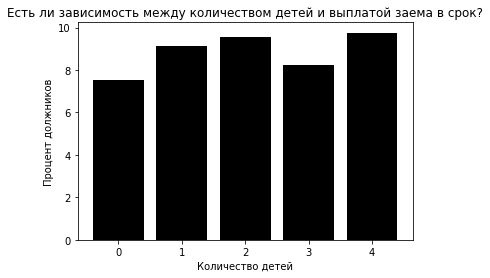

In [22]:
# импортирую библиотеку для визуализации данных
import matplotlib.pyplot as plt
# построю столбчатую диаграмму
plt.bar(children_data['children'],children_data['debt']*100, color='Black')
plt.title('Есть ли зависимость между количеством детей и выплатой заема в срок?')
plt.xlabel('Количество детей')
plt.ylabel('Процент должников')
plt.show()

Исходя из полученных данных очевидно что очевидной зависимости между количеством детей и выплатой заема в срок не наблюдается. Можно наблюдать лишь общую динамику снижения количества заемов с увеличением количества детей. В случае, когда у человека 5 детей - нет случаев не возвращения заема в срок.

## Есть ли зависимость между семейным положением и возвратом кредита в срок?

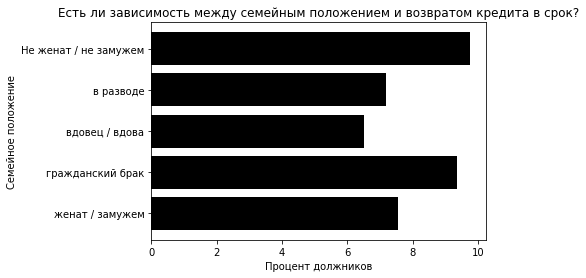

In [23]:
family_data = data.groupby(['family_status_id'])['debt'].mean().reset_index().sort_values('family_status_id')

plt.barh(family_dict['family_status'],family_data['debt']*100, color='Black')
plt.title('Есть ли зависимость между семейным положением и возвратом кредита в срок?')

plt.xlabel('Процент должников')
plt.ylabel('Семейное положение')

plt.show()

ВЫВОД: Таким образом, исходя из представленных данных можно сделать вывод что среди тех,
кто не находился в браке (официально не был расписан), наблюдается чуть больший процент задолженников.

## Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

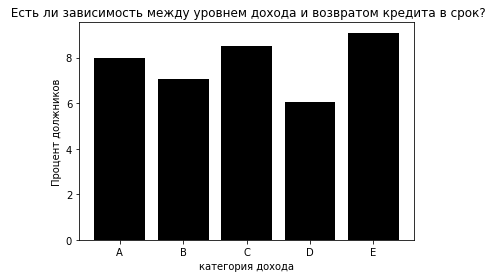

In [24]:
income_data = data.groupby(['total_income_category'])['debt'].mean().reset_index().sort_values('total_income_category')

plt.bar(income_data['total_income_category'], income_data['debt']*100, color='Black')
plt.title(' Есть ли зависимость между уровнем дохода и возвратом кредита в срок?')
plt.xlabel('категория дохода')
plt.ylabel('Процент должников')

plt.show()

ВЫВОД: По полученным данным нельзя сказать что наблюдается какая-то зависимость между уровнем дохода и количеством должников.

## Как разные цели кредита влияют на его возврат в срок?

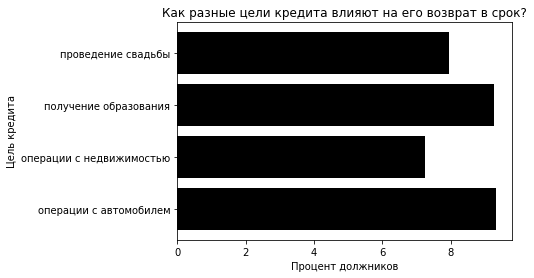

In [25]:
purpose_data = data.groupby(['purpose_category'])['debt'].mean().reset_index().sort_values('purpose_category')

plt.barh(purpose_data['purpose_category'], purpose_data['debt']*100, color='Black')
plt.title('Как разные цели кредита влияют на его возврат в срок?')
plt.xlabel('Процент должников')
plt.ylabel('Цель кредита')

plt.show()

ВЫВОД: Исходя из представленных данных можно сказать что нет одной большой тенденции, связанной с целью кредита и выплатой его в срок. 

В итоге, ответив на 4 вопроса можно сказать что ни семейное положение, ни количество детей, ни уровень дохода, ни цель кредита не влияют на возврат денег в срок. Но что-то должно влиять, продолжим исследование. Проверим влияет ли гендер, образование,то, кем человек работает и возраст на возврат денежных средств в срок.

1. Как влияет образование на возврат денежных средств в срок?

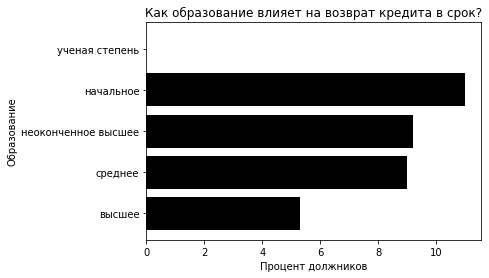

In [26]:
education_data = data.groupby(['education_id'])['debt'].mean().reset_index().sort_values('education_id')

plt.barh(education_dict['education'], education_data['debt']*100, color='Black')
plt.title('Как образование влияет на возврат кредита в срок?')
plt.xlabel('Процент должников')
plt.ylabel('Образование')

plt.show()

ВЫВОД: А вот образование заемщика имеет прямое влияние на процент должников. Чем ниже уровень образования - тем выше процент должников по кредиту.

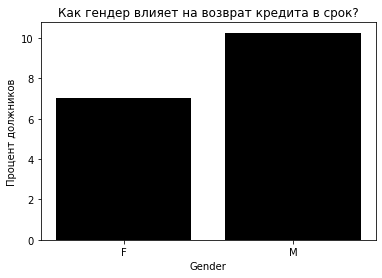

In [27]:
gender_data = data.groupby(['gender'])['debt'].mean().reset_index().sort_values(by='gender')

plt.bar(gender_data['gender'], gender_data['debt']*100, color='Black')
plt.title('Как гендер влияет на возврат кредита в срок?')
plt.xlabel('Gender')
plt.ylabel('Процент должников')

plt.show()

**ВЫВОД:** Здесь мы очевидно наблюдаем зависимость - мужчины чаще просрачивают платежи по кредитам, нежели женщины.

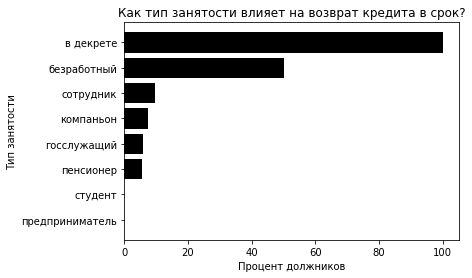

In [28]:
income_data = data.groupby(['income_type'])['debt'].mean().reset_index().sort_values('debt')

plt.barh(income_data['income_type'], income_data['debt']*100, color='Black')
plt.title('Как тип занятости влияет на возврат кредита в срок?')
plt.xlabel('Процент должников')
plt.ylabel('Тип занятости')

plt.show()

Наблюдается очевидная зависимоть - неблагонадежными заемщиками, просрачивающими выплаты по кредитам можно назвать людей в декрете и безработных. Студенты, по-видимому имеют нулевой процент по задолженностям ввиду того что находятся под опекой родителей, которые помогают внести деньги в срок. 

Однако данные о типе занятости могут ничего не значить, надо просмотреть их в сумме с доходом человека, тогда, возможно, картина будет более полная.

In [29]:
# получим сводную таблицу, NaN заменим на прочерки
pd.pivot_table(data, index=['income_type'], columns='total_income_category', values='debt').fillna('--')

total_income_category,A,B,C,D,E
income_type,,,,,
безработный,--,0.0,1.0,--,--
в декрете,--,--,1.0,--,--
госслужащий,--,0.048913,0.063327,0.041667,0.0
компаньон,0.133333,0.06351,0.079781,0.04,0.0
пенсионер,--,0.056673,0.056763,0.042683,0.133333
предприниматель,--,0.0,--,--,--
сотрудник,0.0,0.082875,0.099483,0.088889,0.0
студент,--,--,0.0,--,--


Полученные данные свидетельствуют о том что люди могут работать кем угодно, и среди самых разных разных достатков есть те кто платят в срок и те, кто просрачивают платежи по кредитам.

Рассмотрим, наконец, как влияет возраст на то, как люди платят по кредиту. Привычным методом сгруппируем таблицу и визуализируем ее.

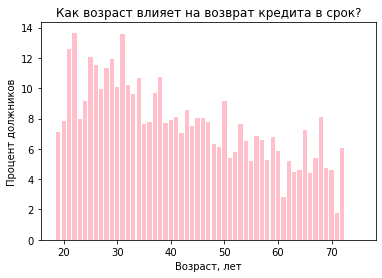

In [30]:
age_data = data.groupby(['dob_years'])['debt'].mean().reset_index().sort_values(by='debt')
#display(age_data)
plt.bar(age_data['dob_years'], age_data['debt']*100, color='Pink')
plt.title('Как возраст влияет на возврат кредита в срок?')
plt.xlabel('Возраст, лет')
plt.ylabel('Процент должников')

plt.show()

## ИТОГОВЫЕ ВЫВОДЫ:
    ЧТО НЕ ВЛИЯЕТ НА ВОЗВРАТ КРЕДИТА В СРОК:
    1. Количество детей не влияет на то как люди выплачивают кредит. За одним исключением - в случае 5ти детей 100% взятых кредитов были выплачены в срок.
    2. В целом семейное положение не влияет на то как люди выплачивают кредиты. Можно лишь отметить что среди тех кто не состоял в официальном браке (холостые или находящиеся в гражданском браке) процент должников  выше 9% (для остальных - ниже 8%)
    3. Зависимости между уровнем достатка и возвратом кредита в срок не наблюдается.
    4. Цели на взятие кредита не влияют на то, как люди вносят деньги.
    ЧТО ВЛИЯЕТ НА ВОЗВРАТ КРЕДИТА В СРОК:
    1. Образование. Чем выше уровень образования тем меньше процент должников.
    2. Гендер. Мужчины чаще не вносили деньги в срок.
    3. Возраст. В целом наблюдается тенденция - чем выше возраст, тем меньше просрочек по кредитам.
Рассматривать отдельно как влияет тип занятости на то как происходит платеж по кредиту, мне показалось неправильным, поэтому я рассмотрела вместе тип занятости и доход - зависимости не наблюдалось. 